## MMD DCGAN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision


In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# !nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cuda:0


In [4]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

torch.Size([128, 1, 28, 28])


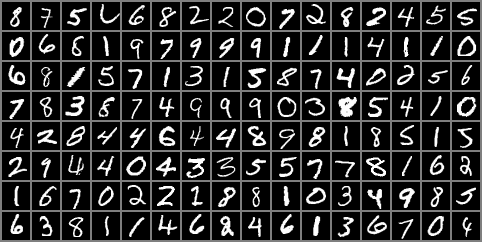

In [5]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to(device),nrow=16))

In [6]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
# import torchsummary

# # Create some generator and discriminator
# netG = Generator().to(device)
# netD = Discriminator().to(device)

# torchsummary.summary(netG, input_size=(nz,1,1))
# torchsummary.summary(netD, input_size=(1,28,28))


In [7]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100,device = device):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to(device),nrow=16))
    return(pil_img)

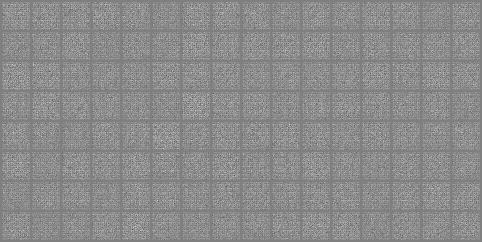

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

    def forward(self, img):
        features = self.model(img)
        return features

## MMD GAN

In [14]:
def MMD(x, y):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    x = x.view(x.size(0), -1)  # [batch_size, features]
    y = y.view(y.size(0), -1)  # [batch_size, features]

    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    """
    print(rx.t().shape)
    print(ry.shape)
    print(zz.shape)
    """
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))


    #rbf kernel
    #bandwidth_range = [10, 15, 20, 50]
    bandwidth_range = [2, 5, 10, 20, 40, 80]
    for a in bandwidth_range:
      XX += torch.exp(-0.5*dxx/a)
      YY += torch.exp(-0.5*dyy/a)
      XY += torch.exp(-0.5*dxy/a)

    return torch.mean(XX + YY - 2. * XY)

## Gradient Penalty 

In [15]:

def gradient_penalty(D, x, y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n > b:
        y = y[0:b, :, :, :]
        n = b
    else:
        x = x[0:n, :, :, :]
        b = n
    # compute interpolated points
    alpha = torch.rand((b, 1, 1, 1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
                                    create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients = gradients.view(b, -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)  # Add epsilon to avoid numerical instability

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()

## TRAIN MMD-DCGAN

sur gpu

In [16]:
# MODIFIED MMD GAN
torch.manual_seed(1)  # initialize random seed for reproducibility
from tqdm import tqdm

log_every = 200
gpw = 0.05

G = Generator().to(device)
D = Discriminator().to(device)
feature_extractor = FeatureExtractor().to(device)
G.apply(weights_init);
D.apply(weights_init);

optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size,nz,1,1).to(device)

In [13]:
gpw = 0.1
num_epochs = 10
#sorry for the bad code, I am in a hurry
losses = []
t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(tqdm(train_loader, 0), 0):

        real = batch[0].to(device)
        
        optimG.zero_grad()

        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()
        output = D(fake) # this is the output of the discrimator 
        
        #gp = gradient_penalty(D,real,fake)
        
        mmd_loss = MMD(real.view(real.size(0), -1), fake.view(output.size(0), -1))        #Gloss = torch.mean(MMD(real,fake)) + gpw*gp
        Gloss = mmd_loss #+ gpw*gp

        
        Gloss.backward(retain_graph=True)
        optimG.step()

        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_G: %.4f\t'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Gloss.item()))
            losses.append(Gloss.item())
    
    
print('Total learning time = ',time.time()-t0)




  0%|          | 0/468 [00:04<?, ?it/s]


out put shape  torch.Size([128])
fake shape  torch.Size([128, 1, 28, 28])


  0%|          | 0/468 [00:03<?, ?it/s]


out put shape  torch.Size([128])
fake shape  torch.Size([128, 1, 28, 28])


  0%|          | 0/468 [00:02<?, ?it/s]


KeyboardInterrupt: 

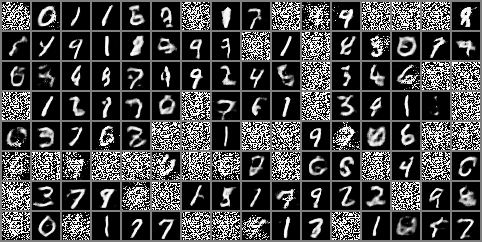

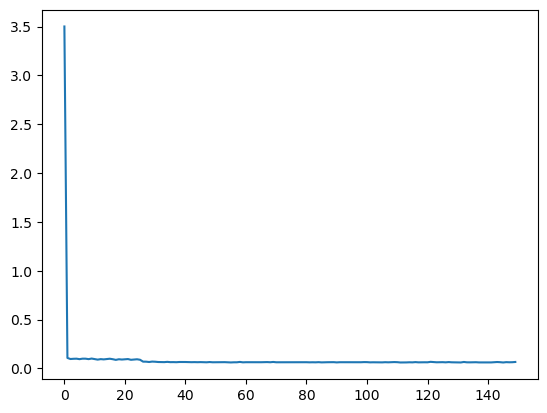

In [64]:
show(G,zviz,device = device)
plt.plot(losses)
plt.show()


35 epochs \
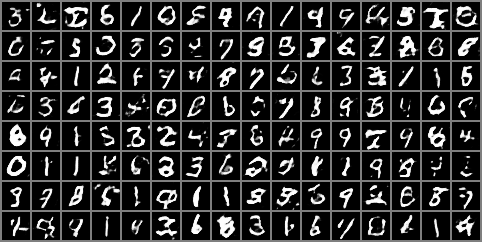

45 epochs\
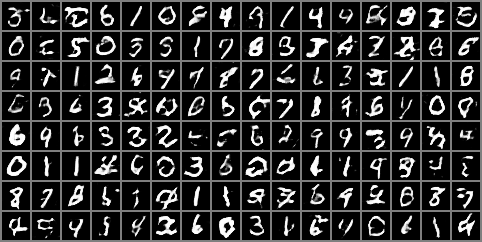

50 epochs\
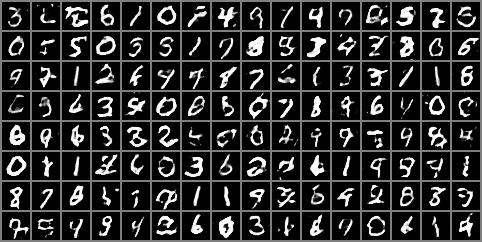

5 epochs with GP\
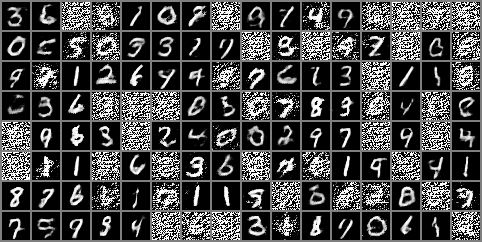
6
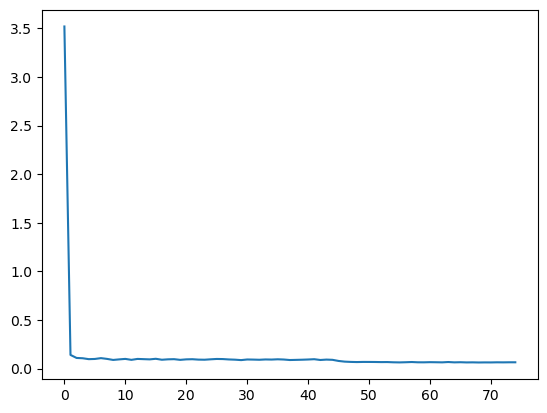

15 epochs with gradient penalty 0.1\

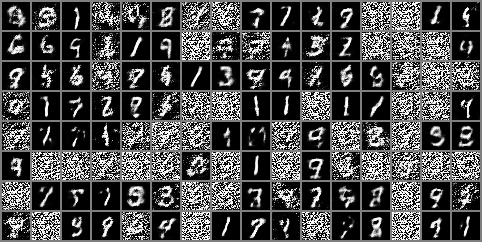\


948.7362341880798\


GP 0.05  \

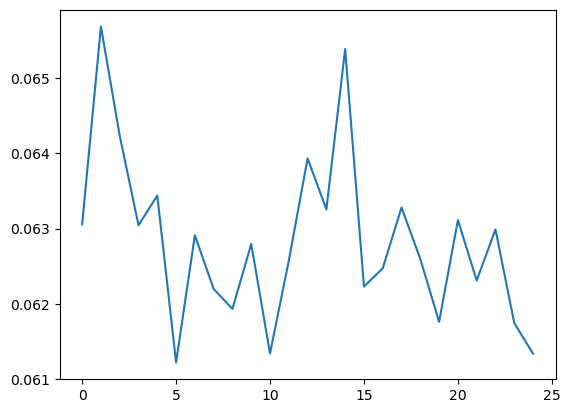\
Numbers are way cleaner with the gradient penalty \

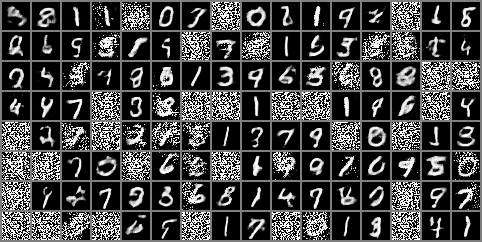


50 epochs with gradient penalty 0.07\
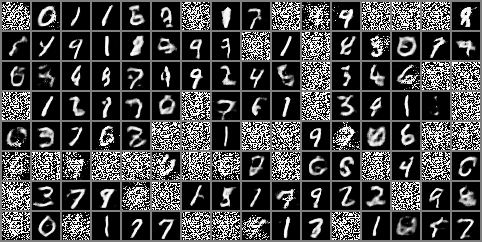




In [65]:
torch.save(G.state_dict(), 'model_weights/generator50epochsGP.pth')
torch.save(D.state_dict(), 'model_weights/discriminator50epochsgp.pth')

## Gradien penalty 

In [ ]:

def gradient_penalty(D, x, y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n > b:
        y = y[0:b, :, :, :]
        n = b
    else:
        x = x[0:n, :, :, :]
        b = n
    # compute interpolated points
    alpha = torch.rand((b, 1, 1, 1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
                                    create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients = gradients.view(b, -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)  # Add epsilon to avoid numerical instability

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()

TODO : Trying to back on the mmd

In [ ]:
num_epochs = 10

t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(tqdm(train_loader, 0), 0):

        ############################
        # Batchs of real and fake images
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()

        ############################
        # Update G network
        ### ... ###
        optimG.zero_grad()

        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        output = D(fake)

        Gloss = torch.mean(MMD(fake,real))
        Gloss.backward()
        optimG.step()

        ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_G: %.4f\t'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Gloss.item()))
        
        #show(G,zviz,device = device)

print('Total learning time = ',time.time()-t0)




In [ ]:
# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())